In [ ]:
import torch.utils.tensorboard as tensorboard
run_dir = ''
stats_tfevents = tensorboard.SummaryWriter(run_dir)

Text(0, 0.5, 'FID')

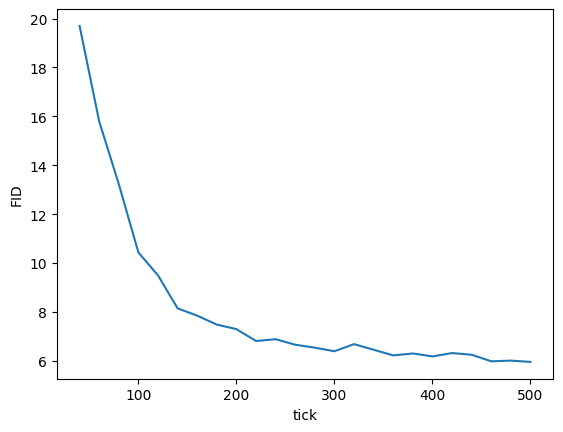

In [1]:
import matplotlib.pyplot as plt

fids= [19.69910812275583, 15.79778262693101, 13.228511324404227, 10.433134136905146, 9.496279620269899, 8.146050423433184, 7.84778060419781, 7.481662798747125, 7.29747371324716, 6.811516276798129, 6.883885988391376, 6.658900452147258, 6.538202961354401, 6.392672558059716, 6.683313974974537, 6.453970736939398, 6.222133861811148, 6.300659931057568, 6.179860949053038, 6.318043953007634, 6.248295760980532, 5.980320989457626, 6.009185805658966, 5.95531264225]
ticks = [40]

for i in range(len(fids) - 1):
    ticks.append(ticks[-1] + 20)

plt.plot(ticks, fids)
plt.xlabel('tick')
plt.ylabel('FID')

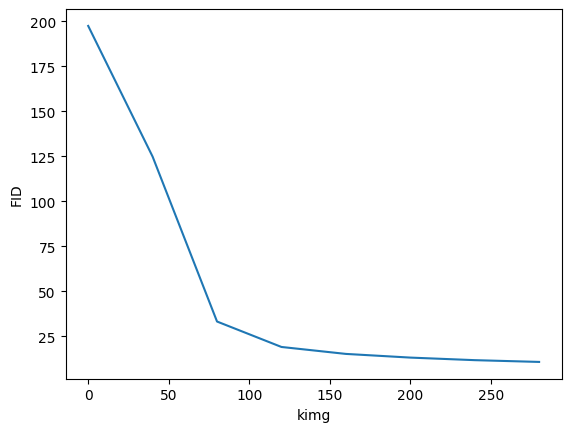

In [8]:
import matplotlib.pyplot as plt

kimg = [0, 40, 80, 120, 160, 200, 240, 280]
plt.plot(kimg, [197.39783556048133, 124.83738918366787, 33.30434845146557, 19.183382696090373, 15.32976294405679, 13.286226209066243, 11.861706686500035, 10.881839771683488])
# plt.plot(kimg, [198.31839331006032, 127.73912096540822, 36.04529621064647, 20.75888725836873, 16.241935795534943, 13.55476101025198, 11.574386736869698, 10.981856947534641])
plt.xlabel('kimg')
plt.ylabel('FID')
plt.savefig('fids.png')

### Test Dataset (adding det)

In [2]:
from datasets import dataset_512
import importlib
importlib.reload(dataset_512)

res = 256
# dpath = '/media/nnthao/MAT/Data/CelebA-HQ/CelebA-HQ-img/'
dpath = '/home/nnthao/lntuong/FDA/test_sets/CelebA-HQ/images'
D = dataset_512.ImageFolderMaskDataset(path=dpath, det_path='/media/nnthao/MAT/label_yolo/CelebA-HQ/CelebA-HQ-img/', xflip=True)
print(D.__len__())
for i in range(D.__len__()):
    print(i)
    a, b, c, d = D.__getitem__(i)
    if a.shape != (3, 512, 512):
        print(i, a.shape)

(3, 512, 512) 0 255
4
0
(3, 512, 512) 0 255
1
(3, 512, 512) 0 255
2
(3, 512, 512) 0 255
3
(3, 512, 512) 0 255


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# a = D._load_raw_det(0)
a = D.__getitem__(0)[3].transpose(1, 2, 0)
plt.imsave('det.png', np.concatenate((a, a, a), axis=2))

### Test-case MAT+yolo

In [ ]:
import matplotlib.image as mpimg
from _my_utils import *

In [30]:
import torch
res = 32
ws = 16
ss = int(ws/2)
# ss = 0
H, W = (res, res)
img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
h_slices = (slice(0, -ws),
            slice(-ws, -ss),
            slice(-ss, None))
w_slices = (slice(0, -ws),
            slice(-ws, -ss),
            slice(-ss, None))

cnt = 0
for h in h_slices:
    for w in w_slices:
        img_mask[:, h, w, :] = cnt
        cnt += 1

In [28]:
import numpy as np
a = np.array(img_mask[0, ...])
a[..., 0]

array([[0., 0., 0., ..., 2., 2., 2.],
       [0., 0., 0., ..., 2., 2., 2.],
       [0., 0., 0., ..., 2., 2., 2.],
       ...,
       [6., 6., 6., ..., 8., 8., 8.],
       [6., 6., 6., ..., 8., 8., 8.],
       [6., 6., 6., ..., 8., 8., 8.]], dtype=float32)

In [29]:
import matplotlib.pyplot as plt
plt.imsave('cal_mask32.png', a * np.array([[[1, 1, 1]]]) / 8)

In [31]:
from networks.mat import window_partition
mask_windows = window_partition(img_mask, ws)
mask_windows = mask_windows.view(-1, ws * ws)
attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))

In [ ]:
dpath = 'test_sets/CelebA-HQ/images3/'
mpath = 'test_sets/CelebA-HQ/masks3/'
outdir = 'test_sets/CelebA-HQ/samples3/'

full_imgs = []

for i in range(8):
    full_imgs.append(mpimg.imread(dpath + str(i) + '.png')[..., :-1])
for i in range(8):
    img = mpimg.imread(dpath + str(i) + '.png')[..., :-1]
    mask = mpimg.imread(mpath + str(i) + '.png')[..., :-1]
    full_imgs.append(img * mask)
for i in range(8):
    full_imgs.append(mpimg.imread(outdir + str(i) + '.png'))

plot_images(np.array(full_imgs), 'rectangle', (3, 8))